In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm

%matplotlib inline

In [4]:
PV_norm = pd.read_csv("..\\Relevant data\\Capstone\\solar\\PV_norm.csv",
                      parse_dates=['date_time'],index_col="date_time")

In [5]:
PV_norm.head()

,mean_dir_horiz,mean_diffuse,zenith_dist,GHI,year,month_day,time_of_day,t,daily_cos,daily_sin,yearly_cos,yearly_sin,half_yearly_cos,half_yearly_sin,pred,pred_Q15,norm,norm_Q15
date_time,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:00:00,1,0.999990,0.004363,1.0,0.000012,1.0,0.000024,0.0,0.0,NaN,NaN
2010-01-01 00:01:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:01:00,2,0.999962,0.008727,1.0,0.000024,1.0,0.000048,0.0,0.0,NaN,NaN
2010-01-01 00:02:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:02:00,3,0.999914,0.013090,1.0,0.000036,1.0,0.000072,0.0,0.0,NaN,NaN
2010-01-01 00:03:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:03:00,4,0.999848,0.017452,1.0,0.000048,1.0,0.000096,0.0,0.0,NaN,NaN
2010-01-01 00:04:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:04:00,5,0.999762,0.021815,1.0,0.000060,1.0,0.000119,0.0,0.0,NaN,NaN


In [6]:
# 12 hourly transmissivity
PV_norm_12H = PV_norm.norm.resample('12H').mean()
PV_norm_Q15_12H = PV_norm.norm_Q15.resample('12H').mean()

# Daily transmissivity
PV_norm_D = PV_norm.norm.resample('D').mean()
PV_norm_Q15_D = PV_norm.norm_Q15.resample('D').mean()

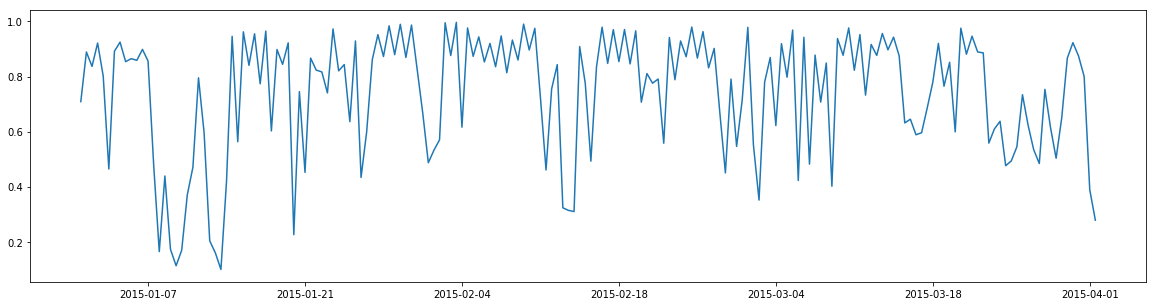

In [7]:
# 12 hourly transmissivity - portion only
plt.figure(figsize=(20,5))
plt.plot(PV_norm_12H['2015-1-1':'2015-4-1']);

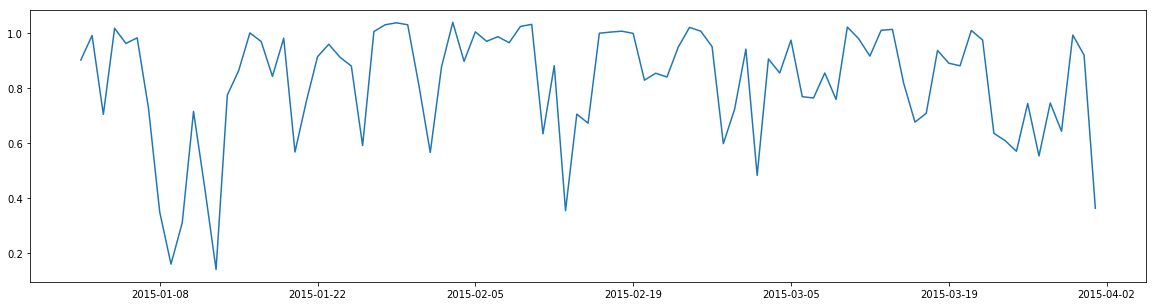

In [8]:
# Daily transmissivity - same portion
plt.figure(figsize=(20,5))
plt.plot(PV_norm['2015-1-1':'2015-4-1'].norm_Q15.resample('D').mean().dropna());

In [9]:
# Check for missing values
PV_norm_Q15_D.isnull().sum()

98

In [10]:
# Impute missing values
PV_norm_Q15_D = PV_norm_Q15_D['2003-03-08':]
PV_norm_Q15_D = PV_norm_Q15_D.interpolate(method='linear')

In [11]:
# Check for missing values
PV_norm_Q15_D.isnull().sum()

0

In [12]:
len(PV_norm_Q15_D)

2922

### Use a grid search to find the optimal ARMA order

In [15]:
from statsmodels.tsa.arima_model import ARIMA

def MAE(predicted,actual):
    return np.nanmean([np.abs(i-j) for i,j in zip(predicted,actual)])

def eval_arima(X, arima_order, freq):
    model = ARIMA(X, list(map(int,arima_order))).fit(disp=0)
    return {'AIC':model.aic,
            'BIC':model.bic,
            'HQIC':model.hqic,
            'log_likelihood':model.llf,
           'MAE':MAE(model.fittedvalues,X)}

In [16]:
eval_arima(PV_norm_Q15_12H,'202','12H')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),


MissingDataError: exog contains inf or nans

In [17]:
p_values = range(0,6) 
d_values = range(0,1)
q_values = range(0,6)

evals = {}
counter = 0
no_combinations = len(p_values) * len(d_values) * len(q_values)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = str(p)+str(d)+str(q)
            try:                
                evals[order] = eval_arima(PV_norm_Q15_12H,order,'12H')
            except:
                evals[order] = np.nan
            counter += 1
            print(counter,'/',no_combinations,'models evaluated','(',order,')')

1 / 36 models evaluated ( 000 )
2 / 36 models evaluated ( 001 )
3 / 36 models evaluated ( 002 )
4 / 36 models evaluated ( 003 )
5 / 36 models evaluated ( 004 )
6 / 36 models evaluated ( 005 )
7 / 36 models evaluated ( 100 )
8 / 36 models evaluated ( 101 )
9 / 36 models evaluated ( 102 )
10 / 36 models evaluated ( 103 )
11 / 36 models evaluated ( 104 )
12 / 36 models evaluated ( 105 )
13 / 36 models evaluated ( 200 )
14 / 36 models evaluated ( 201 )
15 / 36 models evaluated ( 202 )
16 / 36 models evaluated ( 203 )
17 / 36 models evaluated ( 204 )
18 / 36 models evaluated ( 205 )
19 / 36 models evaluated ( 300 )
20 / 36 models evaluated ( 301 )
21 / 36 models evaluated ( 302 )
22 / 36 models evaluated ( 303 )
23 / 36 models evaluated ( 304 )
24 / 36 models evaluated ( 305 )
25 / 36 models evaluated ( 400 )
26 / 36 models evaluated ( 401 )
27 / 36 models evaluated ( 402 )
28 / 36 models evaluated ( 403 )
29 / 36 models evaluated ( 404 )
30 / 36 models evaluated ( 405 )
31 / 36 models eval

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [18]:
output = pd.DataFrame(evals).T

In [19]:
output[output.BIC == output.BIC.min()]

,AIC,BIC,HQIC,MAE,log_likelihood


In [20]:
output[output.AIC == output.AIC.min()]

,AIC,BIC,HQIC,MAE,log_likelihood


In [21]:
output

,AIC,BIC,HQIC,MAE,log_likelihood
000,NaN,NaN,NaN,NaN,NaN
001,NaN,NaN,NaN,NaN,NaN
002,NaN,NaN,NaN,NaN,NaN
003,NaN,NaN,NaN,NaN,NaN
004,NaN,NaN,NaN,NaN,NaN
005,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN


### Walk forward validation

The model is retrained on a fixed number of the most recent previous observations at each timestep and used to predict the next timestep.

In [22]:
X = PV_norm_Q15_12H

In [23]:
n_train = len(X) - 100
n_records = len(X)

persistence = [] # Set a baseline
AR1_pred = []
ARMA32_pred = []

actual = []

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    
    # Persistence model
    persistence.append(train[-1]) 

    # Create list of predictions by the AR1 model
    try:
        AR1_model_fit = ARMA(train, order=(1,0)).fit(disp=0)
        AR1_pred.append(AR1_model_fit.forecast(1)[0][0])
    except:
        AR1_pred.append(np.nan) 
    
    # Create list of predictions by the ARMA(3,2) model
    try:
        ARMA32_model_fit = ARMA(train, order=(3,0)).fit(disp=0)
        ARMA32_pred.append(ARMA32_model_fit.forecast(1)[0][0])
    except:
        ARMA32_pred.append(np.nan)     
    
    # Create list of actual observations
    actual.append(test[0])

In [24]:
ARMA32_model_fit.forecast(6)[0]

NameError: name 'ARMA32_model_fit' is not defined

NameError: name 'ARMA_32_pred' is not defined

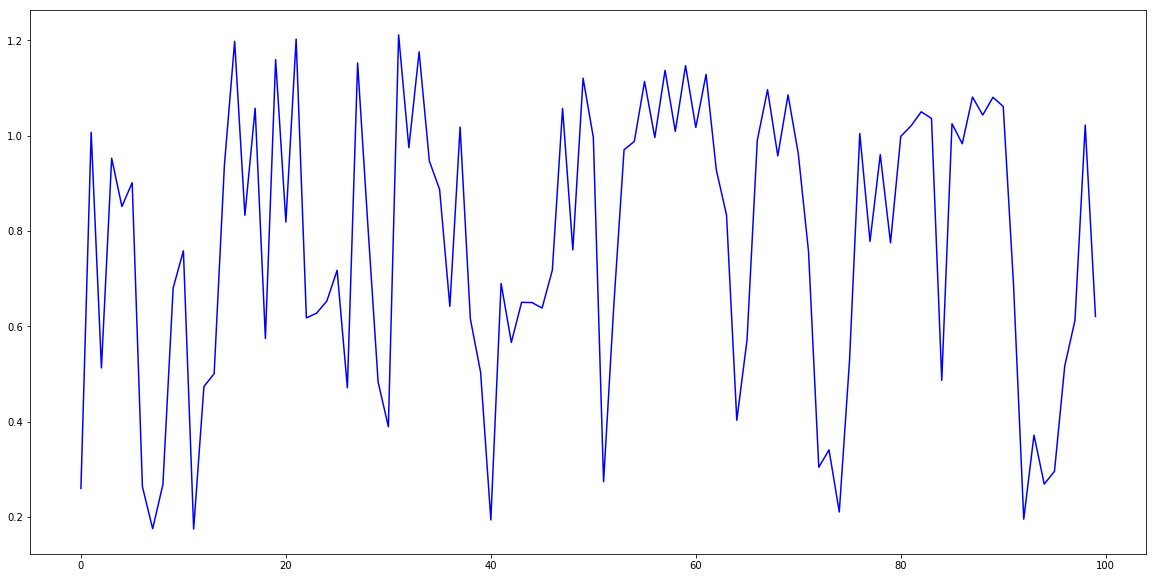

In [25]:
plt.figure(figsize=(20,10))
plt.plot(persistence, 'b-',label='Persistence model')
plt.plot(ARMA_32_pred,'r-',label='ARMA (3,2) model')
plt.plot(AR1_pred, 'c-', label='AR1 model')
plt.plot(actual, 'g-',label='Actual values');

In [26]:
print ('Persistence model MAE:', MAE(persistence,actual))
print ('AR1 model MAE:', MAE(AR1_pred, actual))
print ('ARMA 32 model MAE:', MAE(ARMA_32_pred,actual))

Persistence model MAE: 0.25093541310675294
AR1 model MAE: nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


NameError: name 'ARMA_32_pred' is not defined

In [27]:
len(AR1_pred)

100

In [28]:
from statsmodels.tsa.arima_model import ARMA

AR3_pred = ARMA(X, order=(3,0), freq='12H')
AR3_pred_fit = AR3_pred.fit(trend='nc',disp=0)
AR3_pred_fit.summary()

LinAlgError: Array must not contain infs or NaNs

In [29]:
# Mean average error for fitted model
MAE(AR3_pred_fit.fittedvalues,X)

NameError: name 'AR3_pred_fit' is not defined

### Recreate using linear regression

In [30]:
model_df = pd.concat([X.shift(-1),X.shift(-2),X.shift(-3),X], axis=1)
model_df.columns = ['t-1','t-2','t-3','t']

In [31]:
model_df = model_df.dropna()

In [32]:
# AR3 model
model_fit = sm.OLS(model_df['t'],model_df.iloc[:, 0:3]).fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      t   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 1.854e+04
Date:                Sat, 29 Jun 2019   Prob (F-statistic):               0.00
Time:                        21:33:09   Log-Likelihood:                -107.79
No. Observations:                5513   AIC:                             221.6
Df Residuals:                    5510   BIC:                             241.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t-1            0.5989      0.013     44.830      0.000       0.573       0.625
t-2            0.2578      0.015     16.959      0.000       0.228       0.288
t-3            0.1120      0.013      8.390      0.000       0.086       0.138
==============================================================================
Omnibus:                       51.498   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.116
Skew:                          -0.141   Prob(JB):                     2.67e-15
Kurtosis:                       3.462   Cond. No.                         7.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficients produced by the ARIMA model are very similar to those produced by the linear regression model.  The difference is perhaps due to the method of estimation, least squares vs. maximum likelihood estimation.

In [33]:
list(zip(model_fit.params,AR3_pred_fit.params))

NameError: name 'AR3_pred_fit' is not defined

## Try including weather data as input to the regression model to improve result

In [34]:
# Change these years as required
from_year = 2001
to_year = 2016

year_range = range(from_year,to_year+1)

weather = {}

for year in year_range:      
    weather[str(year)[-2:]] = pd.read_csv(
        '..//weather_data/w_' + str(year) + '.csv',
        parse_dates=['date_time'],
        index_col='date_time')

FileNotFoundError: File b'..//weather_data/w_2001.csv' does not exist

In [35]:
# Years for which (some) data is present
yrs = weather.keys()
yrs

dict_keys([])

In [36]:
# Merge dictionary of dataframes into a single dataframe
weather = pd.concat(weather.values())
weather.head()

ValueError: No objects to concatenate

In [37]:
weather.tail()

AttributeError: 'dict' object has no attribute 'tail'

In [38]:
# Drop unused columns
use_cols = ['temp','wb_temp','dp_temp','rel_humid','wind_spd','visibility','sea_lvl_pressure']
weather = weather[use_cols]

TypeError: unhashable type: 'list'

In [39]:
# Merge solar and weather dataframes into a single dataframe
data = pd.concat([PV_norm,weather], axis=1, join='inner')

TypeError: cannot concatenate object of type "<class 'dict'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [40]:
data.columns

NameError: name 'data' is not defined

In [41]:
data.head()

NameError: name 'data' is not defined

In [42]:
# Check for correlations between lagged values of normalised solar power and weather variables
lagged_norm = pd.concat([data.norm_Q15.shift(1),data.norm_Q15.shift(2),data.norm_Q15.shift(3)], axis=1)

NameError: name 'data' is not defined

In [43]:
lagged_norm.columns = ['t-1','t-2','t-3']

NameError: name 'lagged_norm' is not defined

In [44]:
data = pd.concat([lagged_norm,data], axis=1)

NameError: name 'lagged_norm' is not defined

In [45]:
data.dropna().corr().loc[weather.columns,lagged_norm.columns]

NameError: name 'data' is not defined

There appears to be weak relationships between lagged normalised solar power and temperature, humidity, and sea level pressure.  The Granger-Causality test can also be used to find if humidity 'Granger-causes' changes in solar transmissivity.

In [46]:
print(sm.tsa.stattools.grangercausalitytests(data[['norm_Q15','temp']].dropna(),5))

NameError: name 'data' is not defined

In [47]:
ARMAX_data = data[['norm_Q15', 'temp', 'rel_humid', 'sea_lvl_pressure']]


# Resample to be 12-hourly
ARMAX_data = ARMAX_data.resample('D').mean()

# Create new features - change in weather variables
ARMAX_data['temp_change'] = ARMAX_data['temp'] - ARMAX_data['temp'].shift(1)

# Drop missing values
ARMAX_data = ARMAX_data.dropna()

Y = ARMAX_data.norm_Q15.values
X = ARMAX_data[['temp','sea_lvl_pressure']].values

NameError: name 'data' is not defined

In [48]:
from statsmodels.tsa.arima_model import ARMA

AR1X_pred = ARMA(endog=Y, exog=X, order=(2,0))
AR1X_pred_fit = AR1X_pred.fit(trend='nc',disp=0)
AR1X_pred_fit.summary()

NameError: name 'Y' is not defined

In [49]:
x = AR1X_pred.fit()

NameError: name 'AR1X_pred' is not defined

In [50]:
np.array([X[-1],X[-1]])

array([1.03792052, 1.03792052])

In [51]:
x.forecast(3, exog=np.array([X[-1],X[-1],X[-1]]))[0]

NameError: name 'x' is not defined

Walk forward validation

In [52]:
import winsound

In [53]:
n_train = len(ARMAX_data) - 200
n_records = len(ARMAX_data)

persistence = [] # Set a baseline
AR1X_pred = []

actual = []

for i in range(n_train, n_records):
    train, test = ARMAX_data.iloc[0:i], ARMAX_data.iloc[i:i+1]
    
    Y = train.norm_Q15.values
    X = train[['temp','sea_lvl_pressure']].values
    
    # Persistence model
    persistence.append(Y[-1]) 

    # Create list of predictions by the AR2 model
    try:
        AR1X_model_fit = ARMA(endog=Y, exog=X, order=(2,0)).fit(disp=0)
        AR1X_pred.append(AR1X_model_fit.forecast(3, exog=np.array([X[-1],X[-1],X[-1]]))[0])
    except:
        AR1X_pred.append(np.nan) 
    
    # Create list of actual observations
    actual.append(test.norm_Q15.values[0])

winsound.Beep(500,100)

NameError: name 'ARMAX_data' is not defined

In [54]:
AR1X_pred = pd.DataFrame(AR1X_pred, columns=['pred_t+1','pred_t+2','pred_t+3'])

NameError: name 'AR1X_pred' is not defined

In [55]:
AR1X_pred['actual_t+1'] = actual
AR1X_pred['actual_t+2'] = AR1X_pred['actual_t+1'].shift(-1)
AR1X_pred['actual_t+3'] = AR1X_pred['actual_t+1'].shift(-2)
AR1X_pred = AR1X_pred.dropna()

NameError: name 'AR1X_pred' is not defined

In [56]:
MAE_1 = MAE(AR1X_pred['pred_t+1'], AR1X_pred['actual_t+1'])
MAE_2 = MAE(AR1X_pred['pred_t+2'], AR1X_pred['actual_t+2'])
MAE_3 = MAE(AR1X_pred['pred_t+3'], AR1X_pred['actual_t+3'])

print('Mean Average Error - 1 day ahead forecast: {0:%}'.format(MAE_1))
print('Mean Average Error - 2 day ahead forecast: {0:%}'.format(MAE_2))
print('Mean Average Error - 3 day ahead forecast: {0:%}'.format(MAE_3))

NameError: name 'AR1X_pred' is not defined

In [57]:
MAE_1_persistence = MAE(persistence,AR1X_pred['actual_t+1'])
MAE_2_persistence = MAE(persistence,AR1X_pred['actual_t+2'])
MAE_3_persistence = MAE(persistence,AR1X_pred['actual_t+3'])

print('Mean Average Error - Persistence model - 1 day ahead: {0:%}'.format(MAE_1_persistence))
print('Mean Average Error - Persistence model - 2 day ahead: {0:%}'.format(MAE_2_persistence))
print('Mean Average Error - Persistence model - 3 day ahead: {0:%}'.format(MAE_3_persistence))

NameError: name 'AR1X_pred' is not defined

In [58]:
MAE_1_impr = (MAE_1_persistence - MAE_1) / MAE_1_persistence
MAE_2_impr = (MAE_2_persistence - MAE_2) / MAE_2_persistence
MAE_3_impr = (MAE_3_persistence - MAE_3) / MAE_3_persistence

print('Improvement over persistence model - 1 day ahead: {0:%}'.format(MAE_1_impr))
print('Improvement over persistence model - 2 day ahead: {0:%}'.format(MAE_2_impr))
print('Improvement over persistence model - 3 day ahead: {0:%}'.format(MAE_3_impr))

NameError: name 'MAE_1_persistence' is not defined

In [59]:
plt.close()
plt.figure(figsize=(20,10))
#plt.plot(persistence, 'b-',label='Persistence model', alpha=0.2)
plt.plot(AR1X_pred,'r-',label='ARMA 1,2 model')
plt.plot(actual, 'b-',label='Actual values');

NameError: name 'AR1X_pred' is not defined

<Figure size 1440x720 with 0 Axes>

### Replicate the AR1X model using regression

In [60]:
ARMAX_data.columns

NameError: name 'ARMAX_data' is not defined

In [61]:
ARMAX_data['norm_Q15_t1'] = ARMAX_data['norm_Q15'].shift(1)
ARMAX_data['norm_Q15_t2'] = ARMAX_data['norm_Q15'].shift(2)

NameError: name 'ARMAX_data' is not defined

In [62]:
ARMAX_data = ARMAX_data.dropna()

NameError: name 'ARMAX_data' is not defined

In [63]:
Y = ARMAX_data['norm_Q15']
X = ARMAX_data[['temp','sea_lvl_pressure','norm_Q15_t1','norm_Q15_t2']]

NameError: name 'ARMAX_data' is not defined

In [64]:
sm.OLS(Y,X).fit().summary()

NameError: name 'Y' is not defined